#1. 사전 훈련된 네트워크(pretrained network)

대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크

원본 데이터셋이 충분히 크고 일반적이라면?   

: 이 모델의 계층 구조는 일반적인 모델로 효율적인 역할 가능

#2. 특성 추출(feature extraction)과 미세 조정(fine tuning)

* feature extraction   
사전에 학습된 네트워크의 표현을 사용하여 새로운 샘플에서 특성을 뽑아내는 것

컨브넷 : 연속된 conv층과 pooling 층으로 시작해서 완전 연결 분류기로 끝남.   

> 첫 번째 부분 : 합성곱 기반 층(convolutional base)   이라고 부른다.


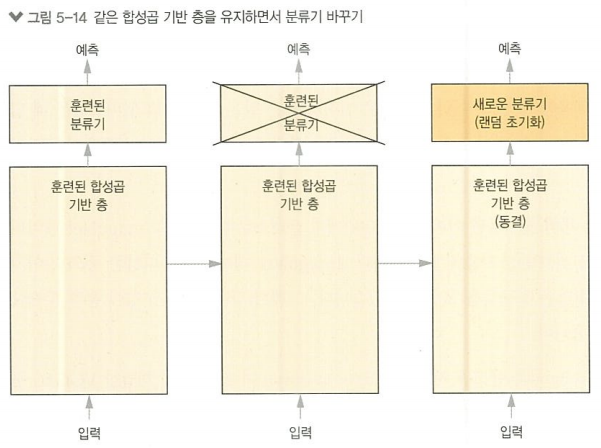

dense layer를 여러 번 쓰지 않는 이유? : convolution layer에 의해 학습된 표현이 더 일반적이기 때문    
> Convnet의 feature map은 사진에 대한 일반적인 콘셉트의 존재 여부를 기록해 놓은 맵이고,   
classifier의 경우, 모델이 훈련한 클래스 집합에 특화되어 있다.

또한, classifier의 경우 위치의 개념이 사라지는데, Convnet은 위치가 중요하기에 크ㅔ 쓸모가 없다.

#3. 일반성

특정 합성곱(conv) 층에서 추출한 표현의 일반성(그리고 재사용성) 수준은 모델에 있는 층(layer)의 깊이에 달려 있다.   
* 하위 층 : 매우 일반적인 feature map 추출
* 상위 층 : 좀 더 복잡하고 추상적인 개념을 추출

새로 학습할 데이터셋이 원래 모델의 데이터셋과 많이 다르다면, 전체보다는 일부분의 하위 층 몇 개만 특성 추출에 사용하는 것이 좋다.

#4. VGG16 모델

사용할 수 있는 이미지 분류 모델은 다음과 같다.

* Xception
* Inception V3
* ResNet50
* VGG16
* VGG19
* MobileNet

In [25]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [26]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

이 지점에서 두 가지 방법이 가능하다.

1. 새로운 데이터셋에서 합성곱 기반 층을 실행하고 출력을 넘파이 배열로 디스크에 저장 -> 데이터 증식 불가능
2. 준비한 모델(conv_base)에 Dense 층을 쌓아 확장 -> 데이터 증식 가능

In [24]:
# 방법 1

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

FileNotFoundError: ignored

In [27]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

NameError: ignored

In [ ]:
# 그래프 그리기
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

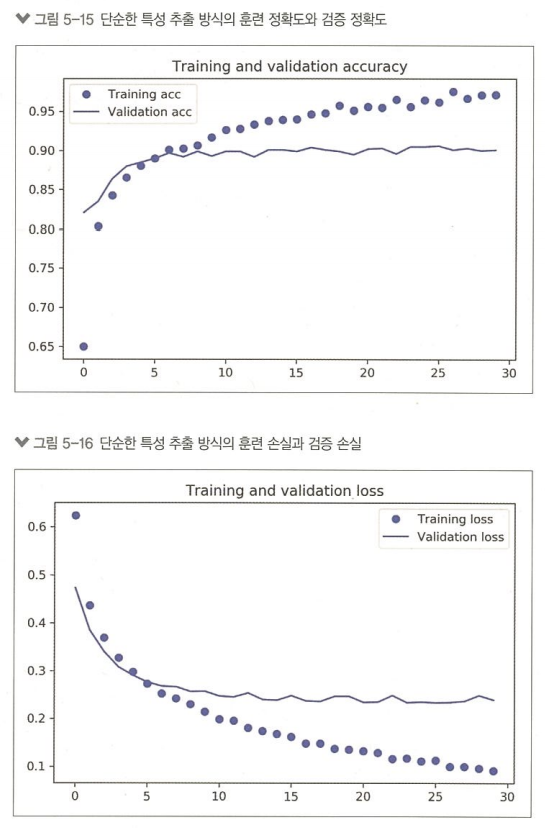

In [9]:
# 방법 2

from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


하나 이상의 layer를 동결한다 : 훈련하는 동안 가중치가 업데이트되지 않도록 한다.
케라스에서는 false를 사용하여 동결을 할 수 있다.

In [12]:
len(model.trainable_weights)

30

In [13]:
conv_base.trainable = False
len(model.trainable_weights)

4

In [35]:
# 두 번째 방법
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

FileNotFoundError: ignored

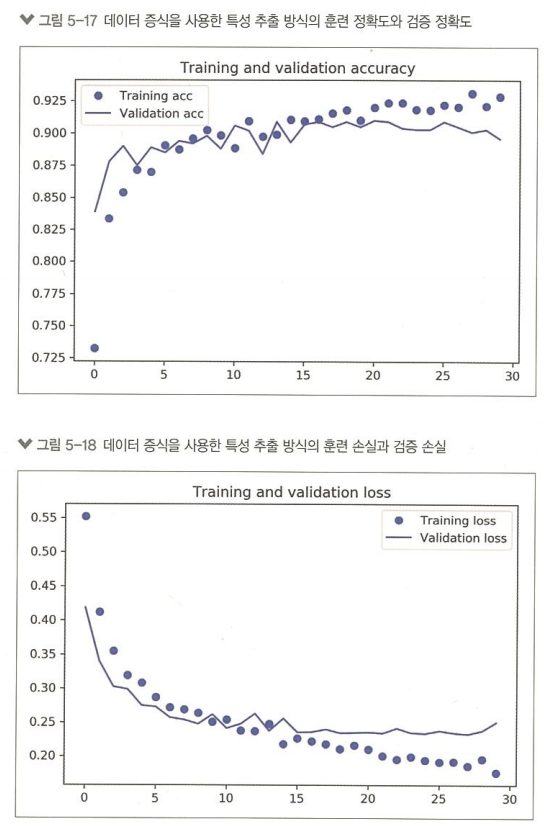

#5. 미세 조정(fine tuning)

특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고, 모델에 새로 추가된 층과 함께 훈련.   
이 예제에서 새로 추가한 층은 완전 연결 분류기이다.

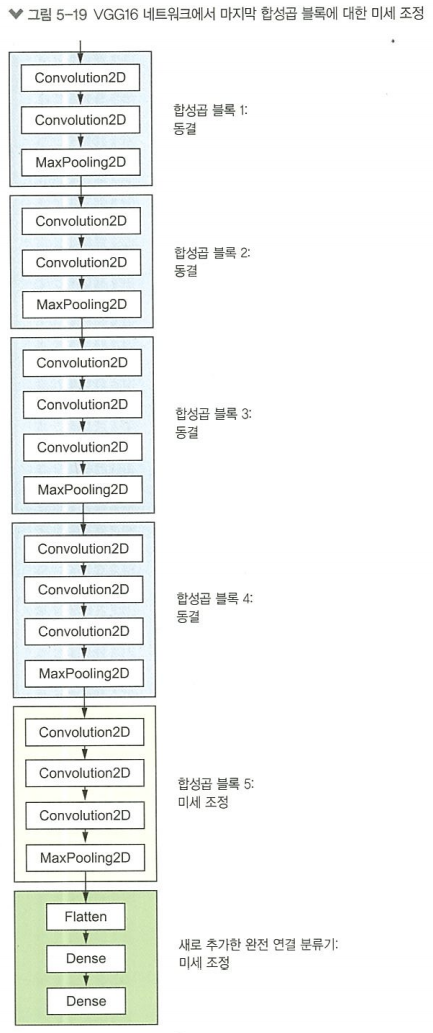

★ 네트워크를 미세 조정하는 단계
* 사전에 훈련된 기반 네트워크 위에 새로운 네트워크 추가
* 기반 네트워크를 동결
* 새로 추가한 네트워크를 훈련
* 기반 네트워크에서 일부 층의 동결을 해제
* 동결을 해제한 층과 새로 추가한 층을 함께 훈련

In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [36]:
# 일부 층의 동결 해제

conv_base.trainable = True

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

FileNotFoundError: ignored

In [41]:
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-5),
                    metrics=['acc'])

    history = model.fit_generator(
          train_generator,
          steps_per_epoch=100,
          epochs=100,
          validation_data=validation_generator,
          validation_steps=50)

NameError: ignored

In [40]:
import matplotlib.pyplot as plt
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [42]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: ignored

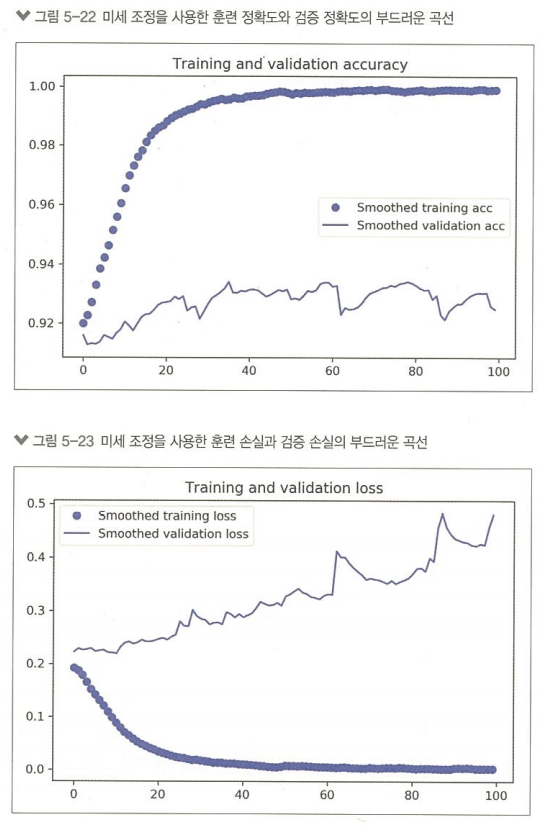